<a href="https://colab.research.google.com/github/DikshantBadawadagi/Encryption-Algorithms/blob/main/Hill%20Climbing%2CStochastic%2CSSimulated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-5-ce518f76c55d>:165: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


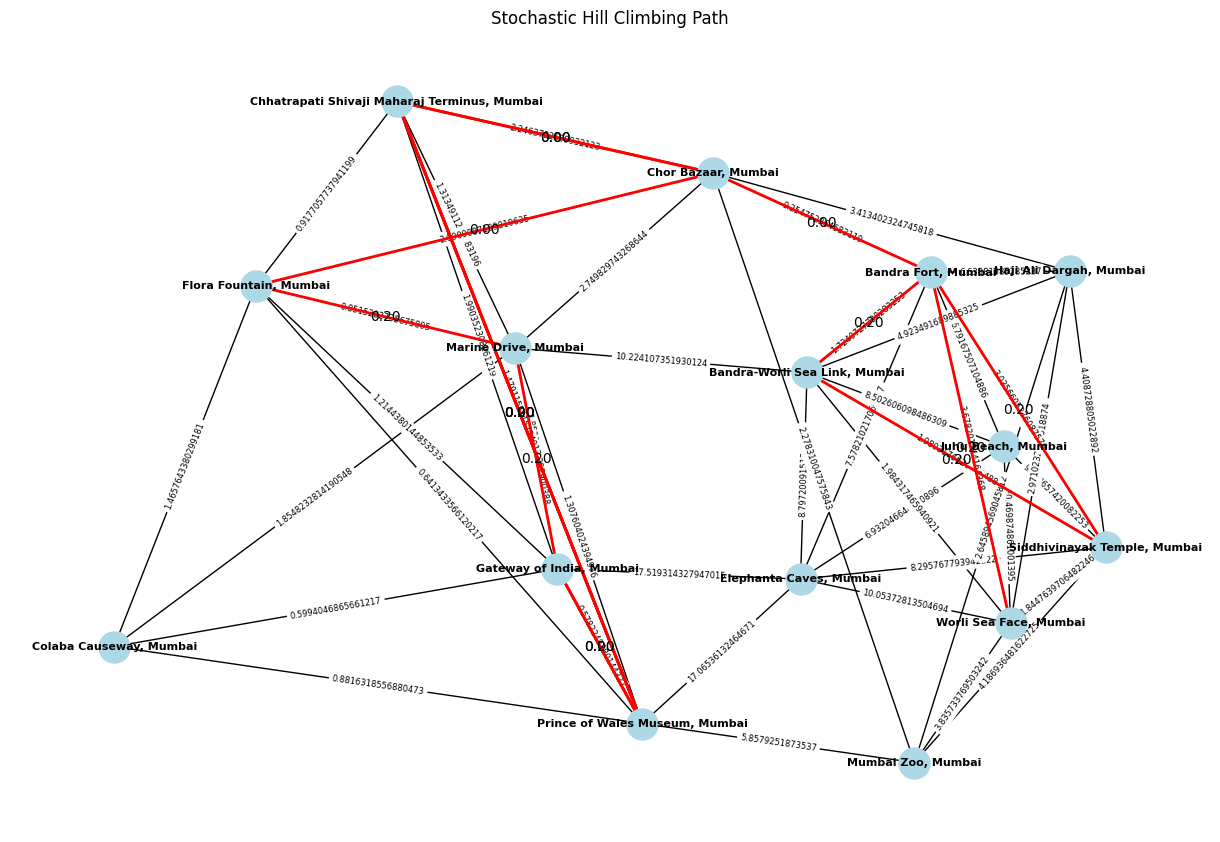

Path from Gateway of India, Mumbai to Worli Sea Face, Mumbai using Stochastic Hill Climbing:
Gateway of India, Mumbai -> Prince of Wales Museum, Mumbai -> Chhatrapati Shivaji Maharaj Terminus, Mumbai -> Prince of Wales Museum, Mumbai -> Chhatrapati Shivaji Maharaj Terminus, Mumbai -> Chor Bazaar, Mumbai -> Flora Fountain, Mumbai -> Marine Drive, Mumbai -> Gateway of India, Mumbai -> Prince of Wales Museum, Mumbai -> Chhatrapati Shivaji Maharaj Terminus, Mumbai -> Chor Bazaar, Mumbai -> Bandra Fort, Mumbai -> Bandra-Worli Sea Link, Mumbai -> Siddhivinayak Temple, Mumbai -> Bandra Fort, Mumbai -> Worli Sea Face, Mumbai


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import requests
import random
from math import radians, sin, cos, sqrt, atan2
import numpy as np

# Your API keys
ORS_API_KEY = "5b3ce3597851110001cf624819318496968841afbf58a43c0804448c"
OPENCAGE_API_KEY = "cb08b03eb9304c969f81e6ba4ed9d0aa"

# Function to get coordinates for a location using OpenCage Geocoding API
def get_coordinates(location):
    base_url = "https://api.opencagedata.com/geocode/v1/json"
    params = {
        'q': location,
        'key': OPENCAGE_API_KEY,
        'limit': 1
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    if data['results']:
        lat = data['results'][0]['geometry']['lat']
        lng = data['results'][0]['geometry']['lng']
        return (lat, lng)
    return None

# Function to calculate distance between two points using Haversine formula
def haversine_distance(coord1, coord2):
    R = 6371  # Earth's radius in kilometers

    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

locations = [
    "Gateway of India, Mumbai",
    "Marine Drive, Mumbai",
    "Chhatrapati Shivaji Maharaj Terminus, Mumbai",
    "Elephanta Caves, Mumbai",
    "Juhu Beach, Mumbai",
    "Colaba Causeway, Mumbai",
    "Haji Ali Dargah, Mumbai",
    "Mumbai Zoo, Mumbai",
    "Bandra-Worli Sea Link, Mumbai",
    "Siddhivinayak Temple, Mumbai",
    "Bandra Fort, Mumbai",
    "Chor Bazaar, Mumbai",
    "Prince of Wales Museum, Mumbai",
    "Flora Fountain, Mumbai",
    "Worli Sea Face, Mumbai"
]


# Get coordinates for each location
coordinates = {}
for location in locations:
    coords = get_coordinates(location)
    if coords:
        coordinates[location] = coords
    else:
        print(f"Warning: Coordinates for '{location}' not found.")

# Create a graph
G = nx.Graph()

# Add nodes to the graph
for location, coords in coordinates.items():
    G.add_node(location, pos=coords)

# Connect each node to at least 4 nearest neighbors
for location in G.nodes():
    distances = [(other_location, haversine_distance(coordinates[location], coordinates[other_location]))
                 for other_location in G.nodes() if other_location != location]
    distances.sort(key=lambda x: x[1])
    for neighbor, distance in distances[:4]:
        G.add_edge(location, neighbor, weight=distance)

# Add some random connections to increase complexity
for _ in range(10):
    node1, node2 = random.sample(list(G.nodes()), 2)
    if not G.has_edge(node1, node2):
        distance = haversine_distance(coordinates[node1], coordinates[node2])
        G.add_edge(node1, node2, weight=distance)

# Implement Stochastic Hill Climbing algorithm with probability
def stochastic_hill_climbing(graph, start, goal, prob_stochastic=0.2):
    def heuristic(node):
        return haversine_distance(coordinates[node], coordinates[goal])

    if not all(node in graph.nodes for node in [start, goal]):
        print(f"Error: One or both nodes ({start}, {goal}) are missing in the graph.")
        return None, None

    current = start
    path = [current]
    path_probabilities = []  # To store the probabilities of the path

    while current != goal:
        neighbors = list(graph.neighbors(current))
        if not neighbors:
            return None, None  # No path found

        next_node = random.choice(neighbors)
        next_heuristic = heuristic(next_node)
        current_heuristic = heuristic(current)

        if next_heuristic < current_heuristic:
            path.append(next_node)
            path_probabilities.append(prob_stochastic)
            current = next_node
        else:
            # Stochastic move: may choose a less optimal neighbor
            if random.random() < prob_stochastic:
                path.append(next_node)
                path_probabilities.append(prob_stochastic)
                current = next_node
            else:
                path_probabilities.append(0)

    return path, path_probabilities

# Define start and goal locations
start_location = "Gateway of India, Mumbai"
goal_location = "Worli Sea Face, Mumbai"

# Find path using Stochastic Hill Climbing
path_stochastic_hill_climbing, probabilities = stochastic_hill_climbing(G, start_location, goal_location)

# Function to visualize the path with probabilities
def visualize_path(graph, path, probabilities, title):
    if path is None or len(path) < 2:
        print(f"No valid path found for {title}.")
        return

    pos = nx.spring_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=6)

    # Highlight the path
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', width=2)

        # Draw probabilities on the edges
        for i, (node1, node2) in enumerate(path_edges):
            # Format probability to 2 decimal places
            prob_text = f'{probabilities[i]:.2f}'
            plt.text((pos[node1][0] + pos[node2][0]) / 2, (pos[node1][1] + pos[node2][1]) / 2,
                     prob_text, color='black', fontsize=10, ha='center', va='center')

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


# Visualize the path with probabilities
if path_stochastic_hill_climbing:
    visualize_path(G, path_stochastic_hill_climbing, probabilities, "Stochastic Hill Climbing Path")

print(f"Path from {start_location} to {goal_location} using Stochastic Hill Climbing:")
print(" -> ".join(path_stochastic_hill_climbing) if path_stochastic_hill_climbing else "No path found")


<ipython-input-7-bc656f2fea9e>:146: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


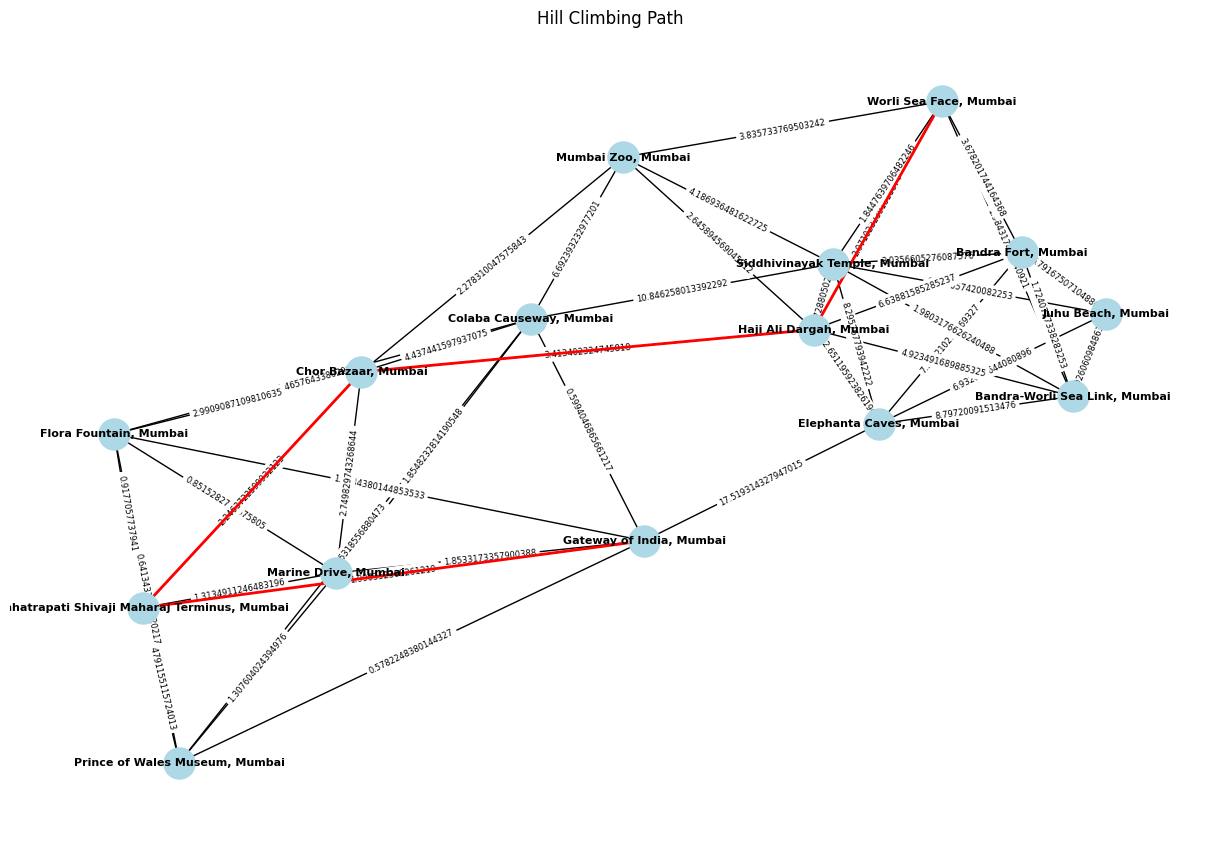

Path from Gateway of India, Mumbai to Worli Sea Face, Mumbai using Hill Climbing:
Gateway of India, Mumbai -> Chhatrapati Shivaji Maharaj Terminus, Mumbai -> Chor Bazaar, Mumbai -> Haji Ali Dargah, Mumbai -> Worli Sea Face, Mumbai


In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import requests
import random
from math import radians, sin, cos, sqrt, atan2

ORS_API_KEY = "5b3ce3597851110001cf624819318496968841afbf58a43c0804448c"
OPENCAGE_API_KEY = "cb08b03eb9304c969f81e6ba4ed9d0aa"

# Function to get coordinates for a location using OpenCage Geocoding API
def get_coordinates(location):
    base_url = "https://api.opencagedata.com/geocode/v1/json"
    params = {
        'q': location,
        'key': OPENCAGE_API_KEY,
        'limit': 1
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    if data['results']:
        lat = data['results'][0]['geometry']['lat']
        lng = data['results'][0]['geometry']['lng']
        return (lat, lng)
    return None

# Function to calculate distance between two points using Haversine formula
def haversine_distance(coord1, coord2):
    R = 6371  # Earth's radius in kilometers

    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

# Define locations in Mumbai
locations = [
    "Gateway of India, Mumbai",
    "Marine Drive, Mumbai",
    "Chhatrapati Shivaji Maharaj Terminus, Mumbai",
    "Elephanta Caves, Mumbai",
    "Juhu Beach, Mumbai",
    "Colaba Causeway, Mumbai",
    "Haji Ali Dargah, Mumbai",
    "Mumbai Zoo, Mumbai",
    "Bandra-Worli Sea Link, Mumbai",
    "Siddhivinayak Temple, Mumbai",
    "Bandra Fort, Mumbai",
    "Chor Bazaar, Mumbai",
    "Prince of Wales Museum, Mumbai",
    "Flora Fountain, Mumbai",
    "Worli Sea Face, Mumbai"
]

# Get coordinates for each location
coordinates = {}
for location in locations:
    coords = get_coordinates(location)
    if coords:
        coordinates[location] = coords
    else:
        print(f"Warning: Coordinates for '{location}' not found.")

# Create a graph
G = nx.Graph()

# Add nodes to the graph
for location, coords in coordinates.items():
    G.add_node(location, pos=coords)

# Connect each node to at least 4 nearest neighbors
for location in G.nodes():
    distances = [(other_location, haversine_distance(coordinates[location], coordinates[other_location]))
                 for other_location in G.nodes() if other_location != location]
    distances.sort(key=lambda x: x[1])
    for neighbor, distance in distances[:4]:
        G.add_edge(location, neighbor, weight=distance)

# Add some random connections to increase complexity
for _ in range(10):
    node1, node2 = random.sample(list(G.nodes()), 2)
    if not G.has_edge(node1, node2):
        distance = haversine_distance(coordinates[node1], coordinates[node2])
        G.add_edge(node1, node2, weight=distance)

# Implement Hill Climbing algorithm
def hill_climbing(graph, start, goal):
    def heuristic(node):
        return haversine_distance(coordinates[node], coordinates[goal])

    if not all(node in graph.nodes for node in [start, goal]):
        print(f"Error: One or both nodes ({start}, {goal}) are missing in the graph.")
        return None

    current = start
    path = [current]

    while current != goal:
        neighbors = list(graph.neighbors(current))
        if not neighbors:
            return None  # No path found

        next_node = min(neighbors, key=lambda neighbor: heuristic(neighbor))

        if heuristic(next_node) >= heuristic(current):
            return None  # No improvement, local maximum reached

        path.append(next_node)
        current = next_node

    return path

# Define start and goal locations
start_location = "Gateway of India, Mumbai"
goal_location = "Worli Sea Face, Mumbai"

# Find path using Hill Climbing
path_hill_climbing = hill_climbing(G, start_location, goal_location)

# Function to visualize the path
def visualize_path(graph, path, title):
    if path is None or len(path) < 2:
        print(f"No valid path found for {title}.")
        return

    pos = nx.spring_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=6)

    # Highlight the path
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', width=2)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the path
if path_hill_climbing:
    visualize_path(G, path_hill_climbing, "Hill Climbing Path")

print(f"Path from {start_location} to {goal_location} using Hill Climbing:")
print(" -> ".join(path_hill_climbing) if path_hill_climbing else "No path found")


<ipython-input-8-0ffad51da189>:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


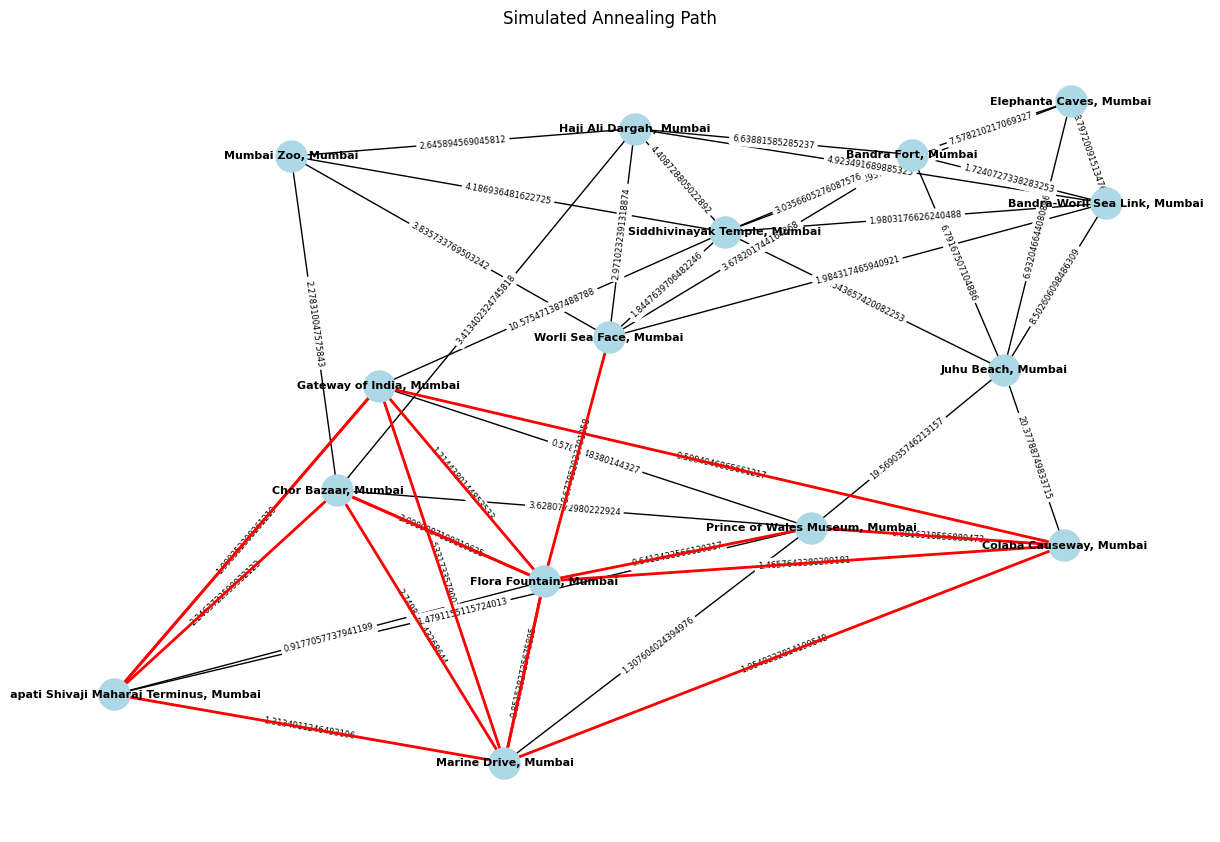

Path from Gateway of India, Mumbai to Worli Sea Face, Mumbai using Simulated Annealing:
Gateway of India, Mumbai -> Colaba Causeway, Mumbai -> Prince of Wales Museum, Mumbai -> Flora Fountain, Mumbai -> Colaba Causeway, Mumbai -> Marine Drive, Mumbai -> Chhatrapati Shivaji Maharaj Terminus, Mumbai -> Gateway of India, Mumbai -> Chhatrapati Shivaji Maharaj Terminus, Mumbai -> Chor Bazaar, Mumbai -> Flora Fountain, Mumbai -> Marine Drive, Mumbai -> Chor Bazaar, Mumbai -> Flora Fountain, Mumbai -> Gateway of India, Mumbai -> Marine Drive, Mumbai -> Flora Fountain, Mumbai -> Worli Sea Face, Mumbai


In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import requests
import random
from math import radians, sin, cos, sqrt, atan2, exp
import numpy as np

ORS_API_KEY = "5b3ce3597851110001cf624819318496968841afbf58a43c0804448c"
OPENCAGE_API_KEY = "cb08b03eb9304c969f81e6ba4ed9d0aa"

# Function to get coordinates for a location using OpenCage Geocoding API
def get_coordinates(location):
    base_url = "https://api.opencagedata.com/geocode/v1/json"
    params = {
        'q': location,
        'key': OPENCAGE_API_KEY,
        'limit': 1
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    if data['results']:
        lat = data['results'][0]['geometry']['lat']
        lng = data['results'][0]['geometry']['lng']
        return (lat, lng)
    return None

# Function to calculate distance between two points using Haversine formula
def haversine_distance(coord1, coord2):
    R = 6371  # Earth's radius in kilometers

    lat1, lon1 = radians(coord1[0]), radians(coord1[1])
    lat2, lon2 = radians(coord2[0]), radians(coord2[1])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

# Define locations in Mumbai
locations = [
    "Gateway of India, Mumbai",
    "Marine Drive, Mumbai",
    "Chhatrapati Shivaji Maharaj Terminus, Mumbai",
    "Elephanta Caves, Mumbai",
    "Juhu Beach, Mumbai",
    "Colaba Causeway, Mumbai",
    "Haji Ali Dargah, Mumbai",
    "Mumbai Zoo, Mumbai",
    "Bandra-Worli Sea Link, Mumbai",
    "Siddhivinayak Temple, Mumbai",
    "Bandra Fort, Mumbai",
    "Chor Bazaar, Mumbai",
    "Prince of Wales Museum, Mumbai",
    "Flora Fountain, Mumbai",
    "Worli Sea Face, Mumbai"
]

# Get coordinates for each location
coordinates = {}
for location in locations:
    coords = get_coordinates(location)
    if coords:
        coordinates[location] = coords
    else:
        print(f"Warning: Coordinates for '{location}' not found.")

# Create a graph
G = nx.Graph()

# Add nodes to the graph
for location, coords in coordinates.items():
    G.add_node(location, pos=coords)

# Connect each node to at least 4 nearest neighbors
for location in G.nodes():
    distances = [(other_location, haversine_distance(coordinates[location], coordinates[other_location]))
                 for other_location in G.nodes() if other_location != location]
    distances.sort(key=lambda x: x[1])
    for neighbor, distance in distances[:4]:
        G.add_edge(location, neighbor, weight=distance)

# Add some random connections to increase complexity
for _ in range(10):
    node1, node2 = random.sample(list(G.nodes()), 2)
    if not G.has_edge(node1, node2):
        distance = haversine_distance(coordinates[node1], coordinates[node2])
        G.add_edge(node1, node2, weight=distance)

# Implement Simulated Annealing algorithm
def simulated_annealing(graph, start, goal, initial_temp=1000, cooling_rate=0.003):
    def heuristic(node):
        return haversine_distance(coordinates[node], coordinates[goal])

    if not all(node in graph.nodes for node in [start, goal]):
        print(f"Error: One or both nodes ({start}, {goal}) are missing in the graph.")
        return None, None

    current = start
    path = [current]
    current_temp = initial_temp

    while current != goal:
        neighbors = list(graph.neighbors(current))
        if not neighbors:
            return None, None  # No path found

        next_node = random.choice(neighbors)
        current_heuristic = heuristic(current)
        next_heuristic = heuristic(next_node)

        # Calculate acceptance probability
        if next_heuristic < current_heuristic:
            # Always accept a better path
            path.append(next_node)
            current = next_node
        else:
            # Accept a worse path with a certain probability
            acceptance_prob = exp((current_heuristic - next_heuristic) / current_temp)
            if random.random() < acceptance_prob:
                path.append(next_node)
                current = next_node

        # Cool down the temperature
        current_temp *= (1 - cooling_rate)

        if current_temp < 1e-3:  # Stop if temperature is very low
            break

    return path

# Define start and goal locations
start_location = "Gateway of India, Mumbai"
goal_location = "Worli Sea Face, Mumbai"

# Find path using Simulated Annealing
path_simulated_annealing = simulated_annealing(G, start_location, goal_location)

# Function to visualize the path
def visualize_path(graph, path, title):
    if path is None or len(path) < 2:
        print(f"No valid path found for {title}.")
        return

    pos = nx.spring_layout(graph)
    plt.figure(figsize=(12, 8))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=6)

    # Highlight the path
    if path:
        path_edges = list(zip(path, path[1:]))
        nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color='r', width=2)

    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the path
if path_simulated_annealing:
    visualize_path(G, path_simulated_annealing, "Simulated Annealing Path")

print(f"Path from {start_location} to {goal_location} using Simulated Annealing:")
print(" -> ".join(path_simulated_annealing) if path_simulated_annealing else "No path found")
